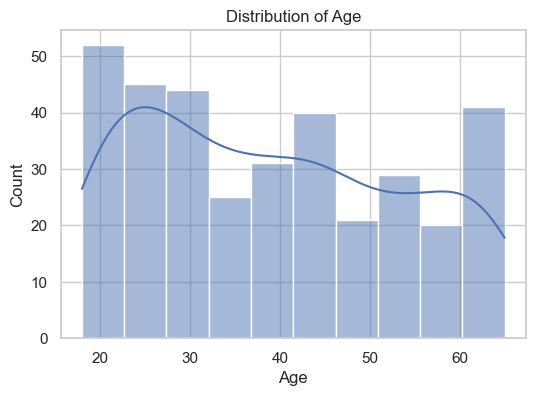

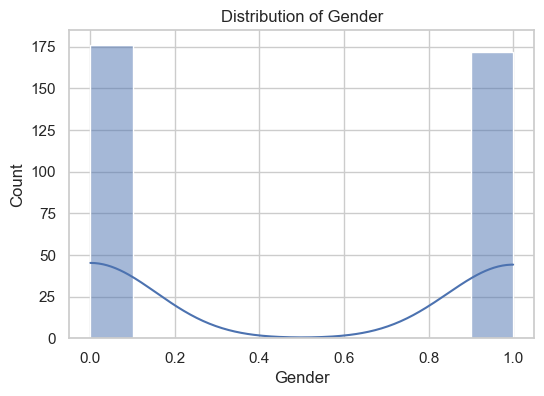

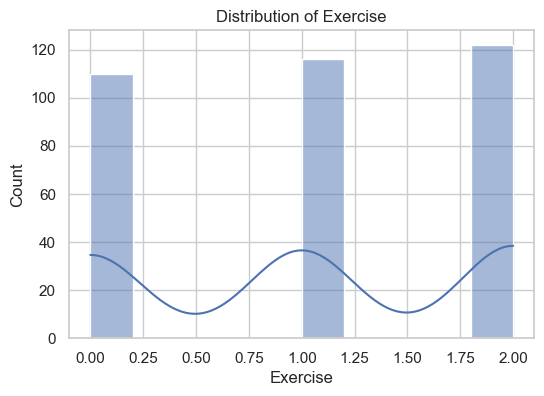

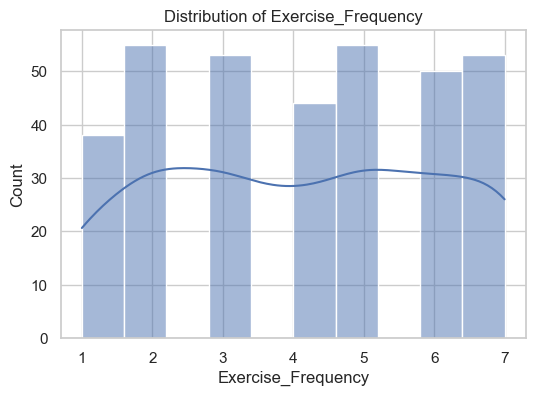

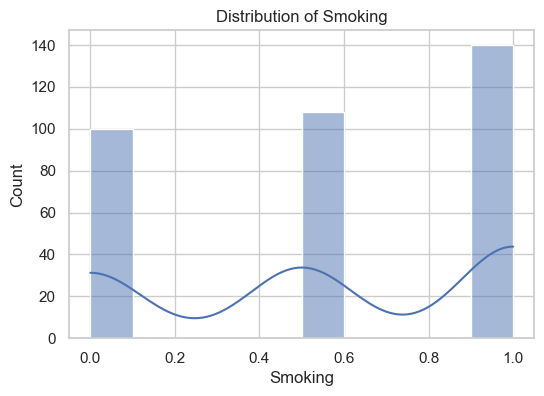

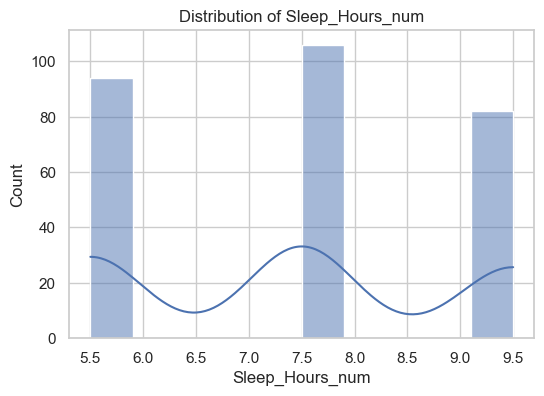

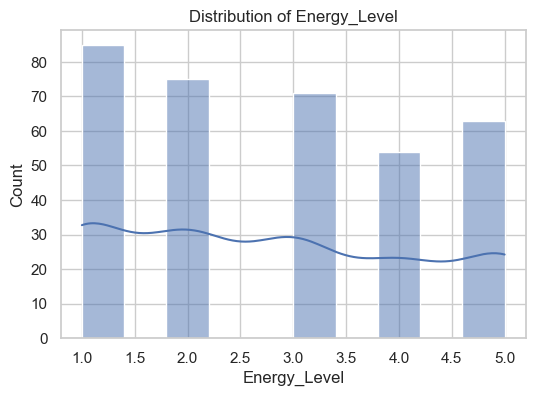

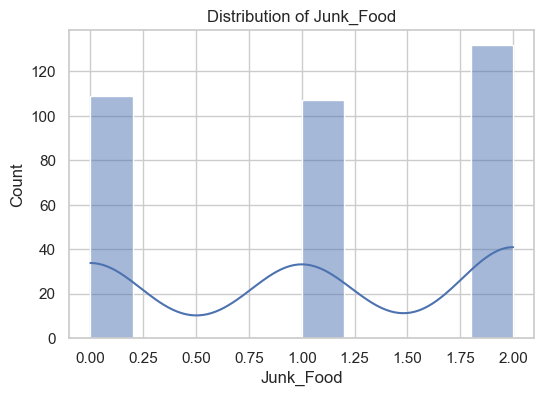

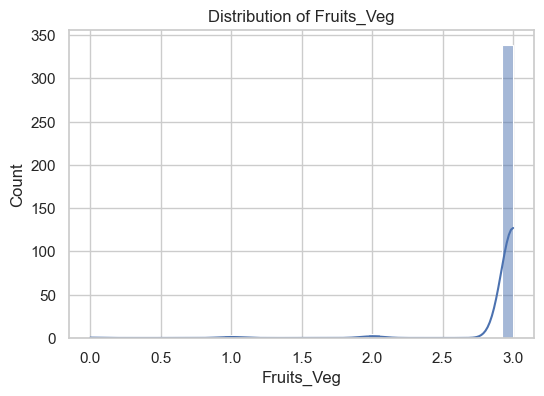

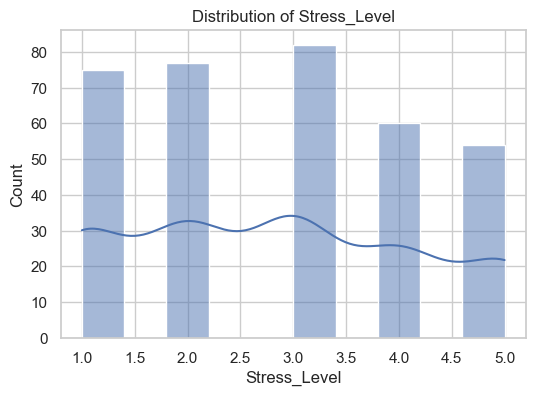

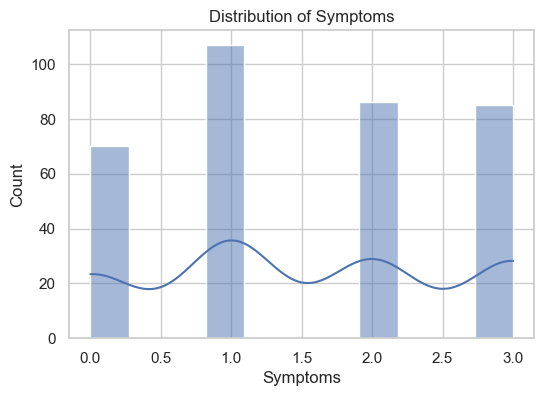

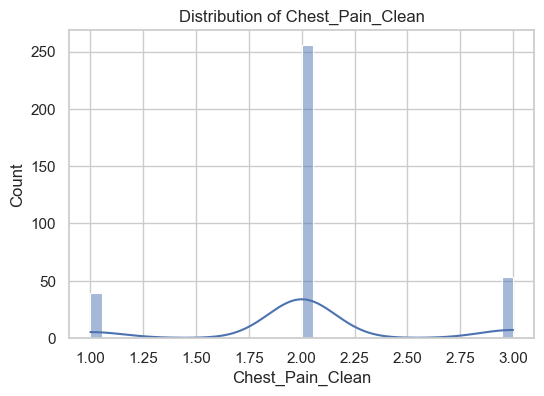

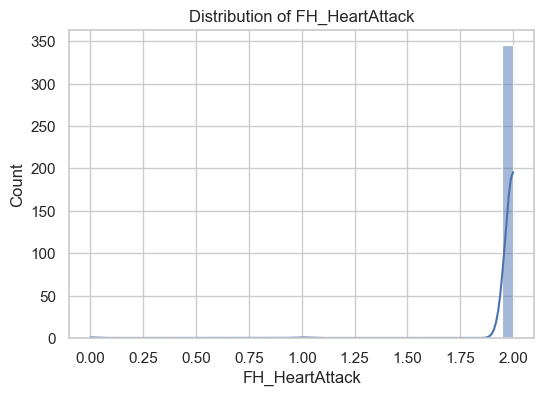

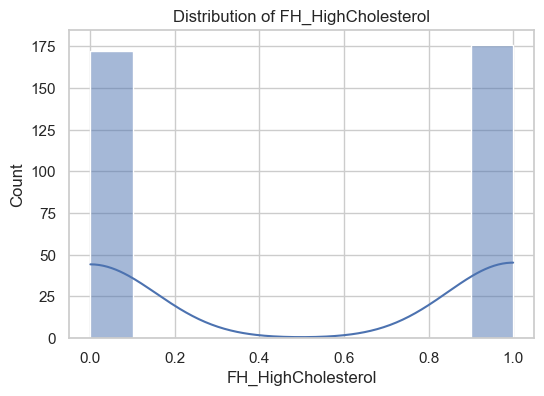

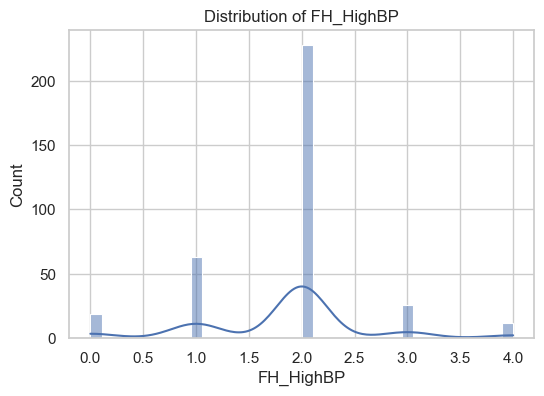

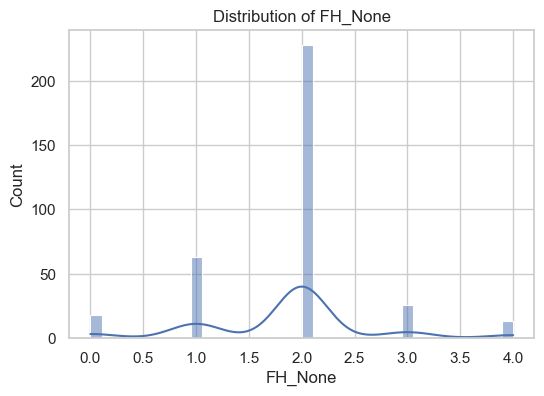

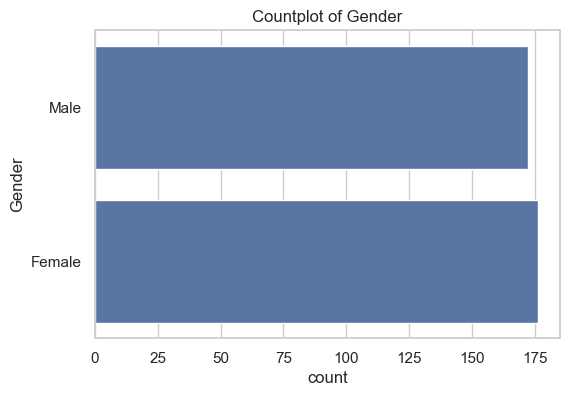

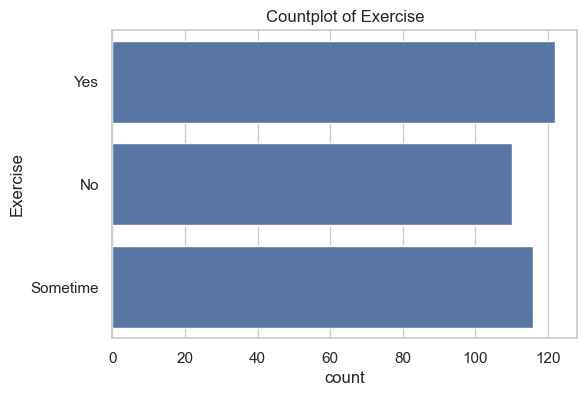

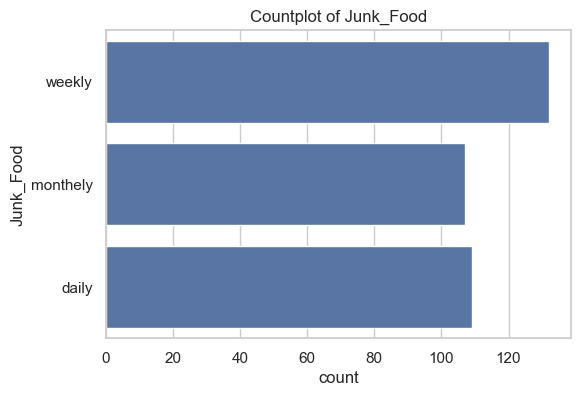

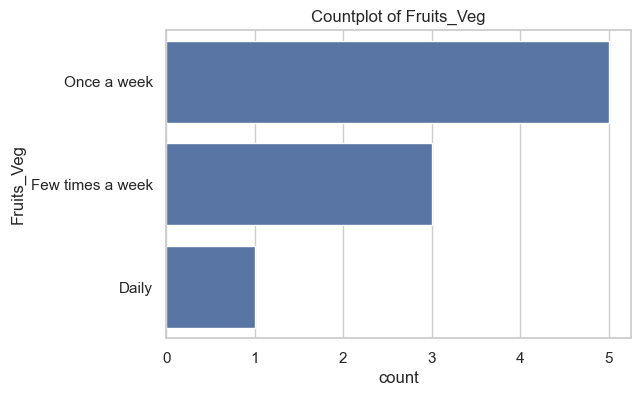

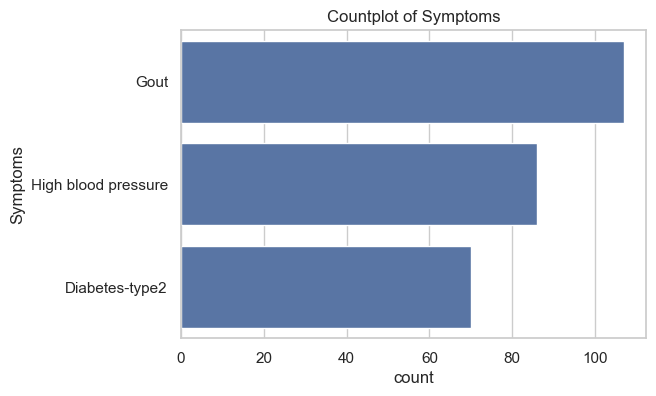

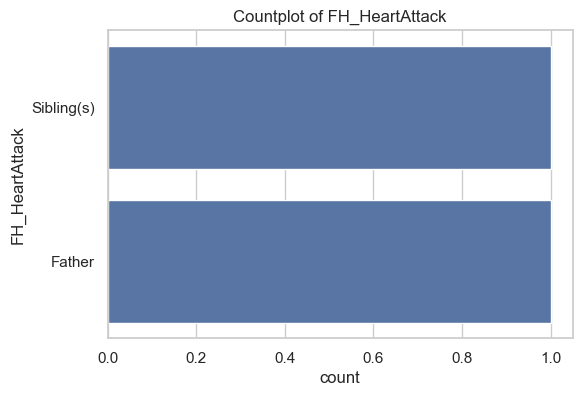

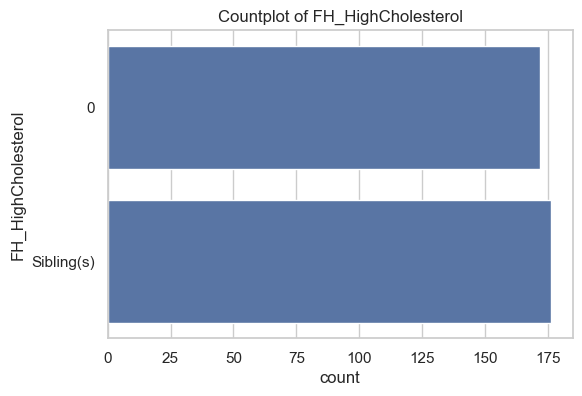

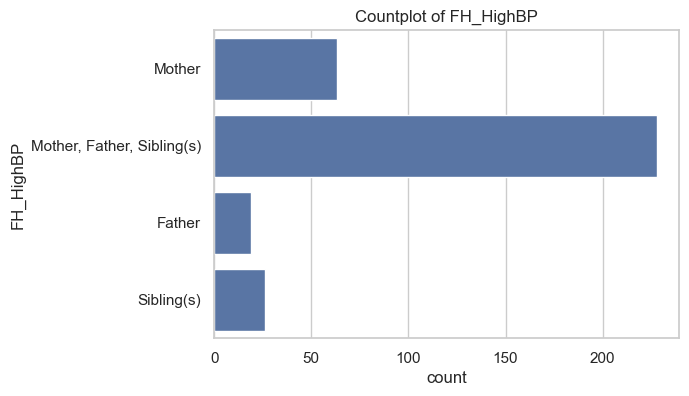

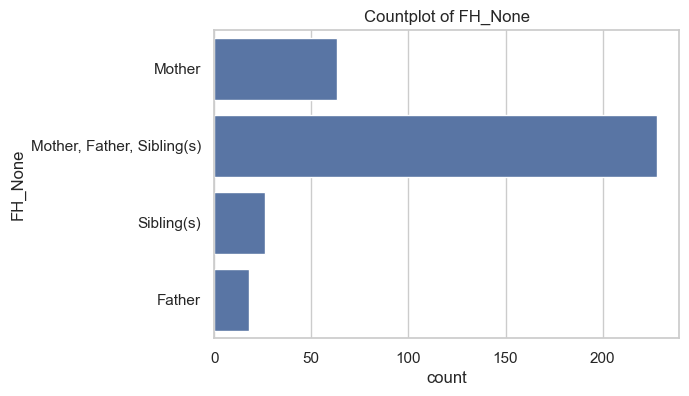

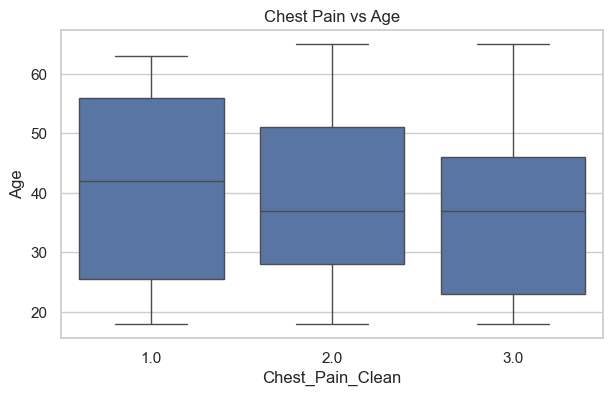

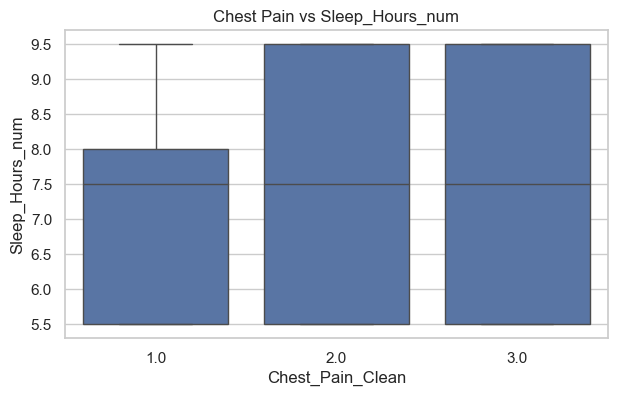

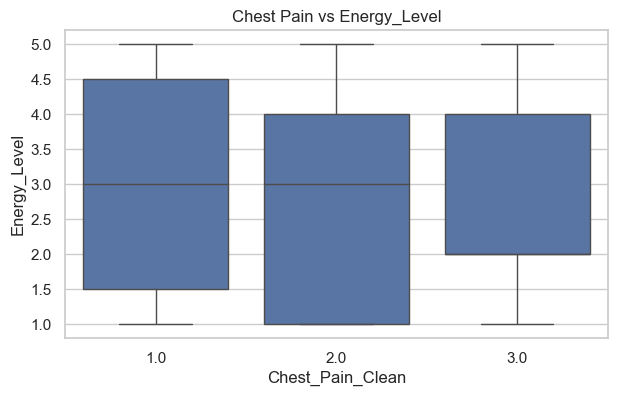

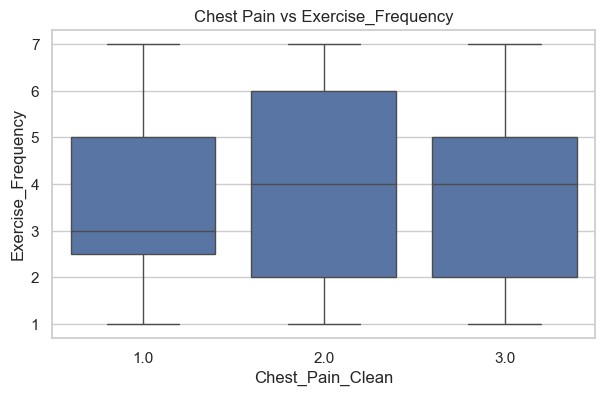

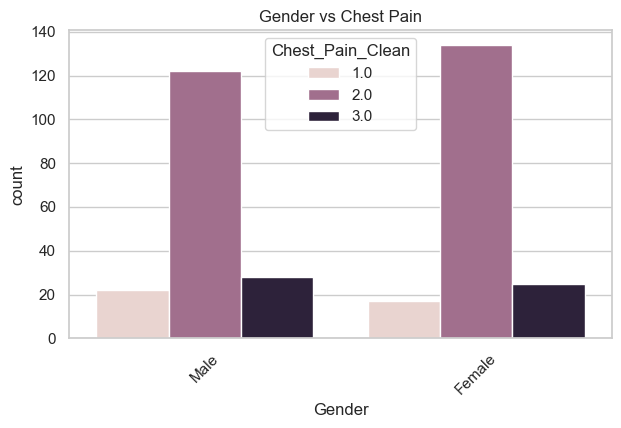

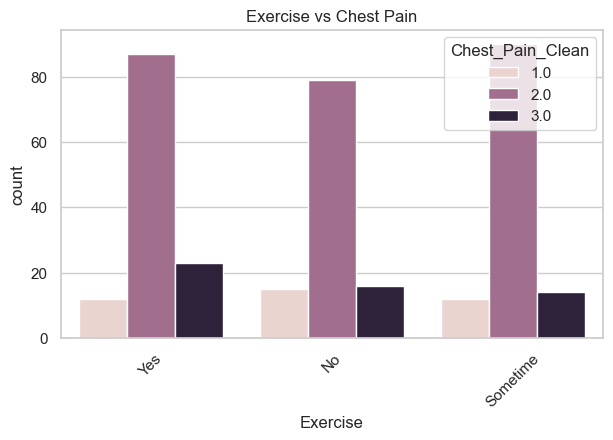

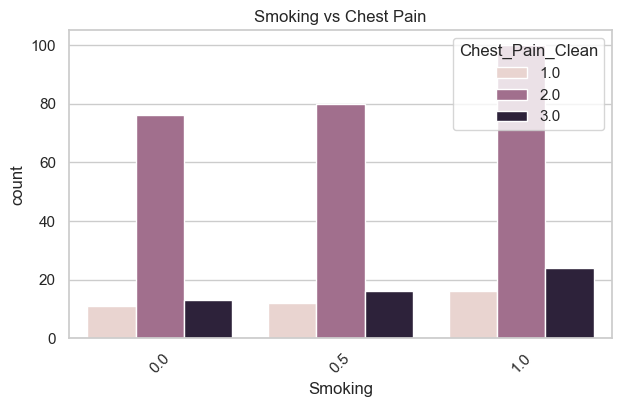

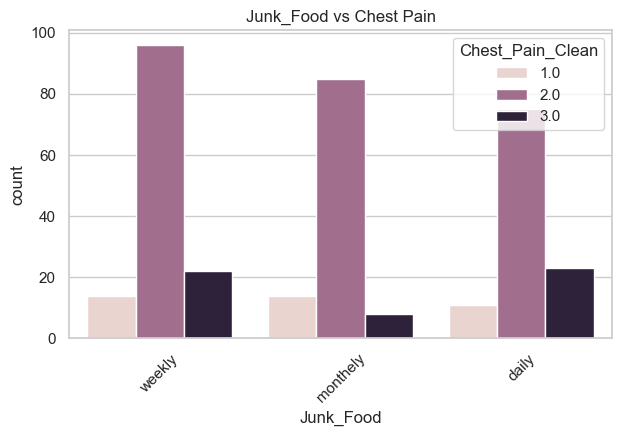

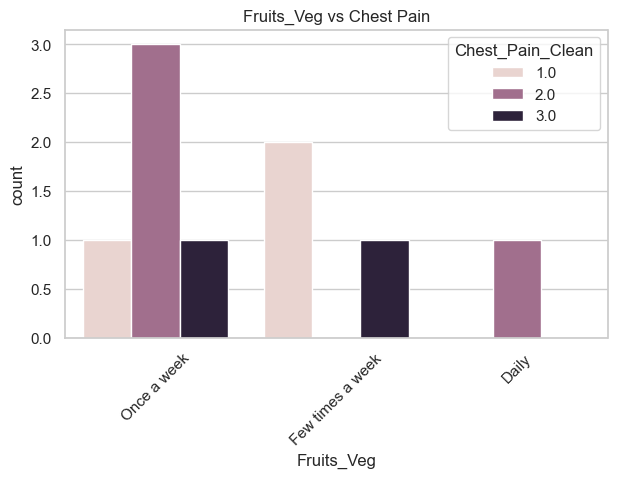

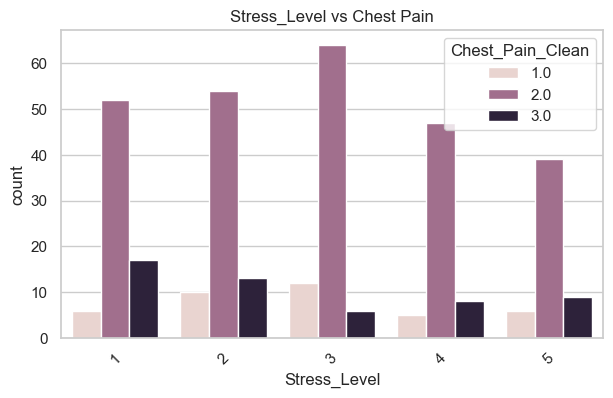

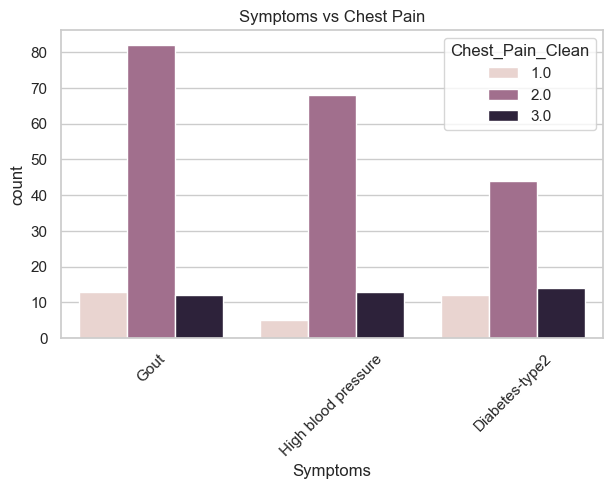

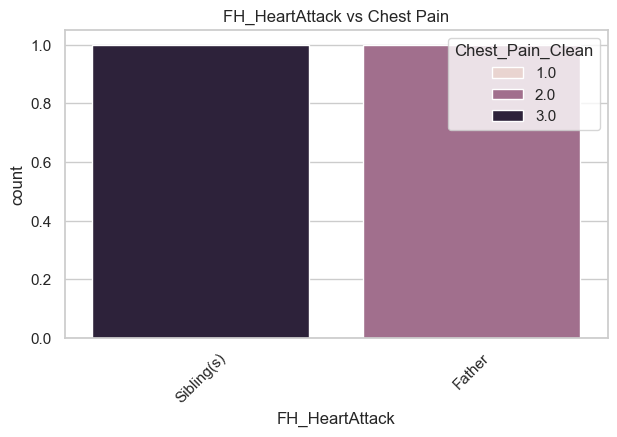

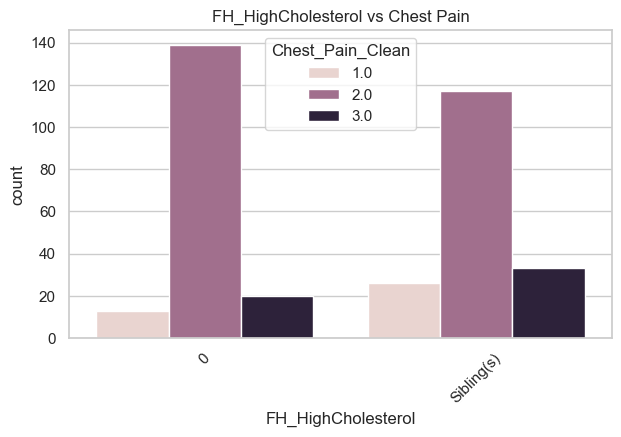

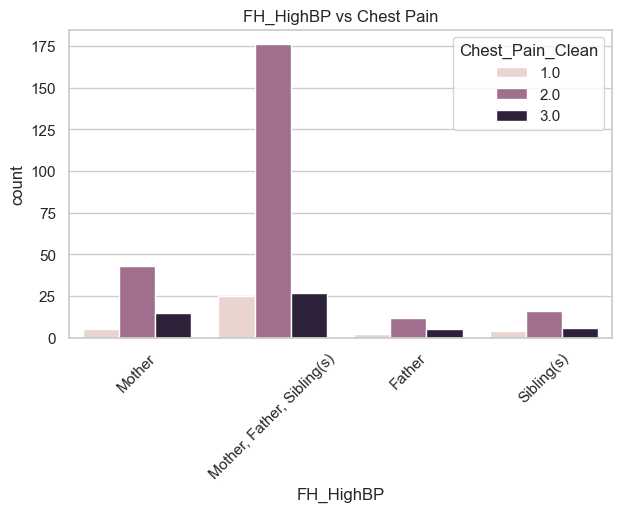

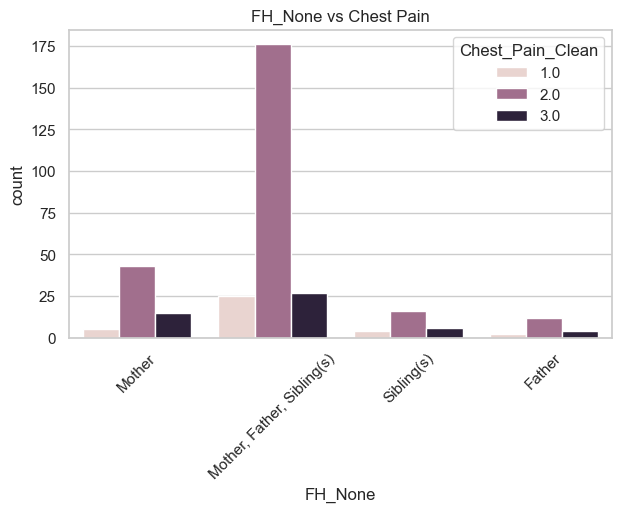

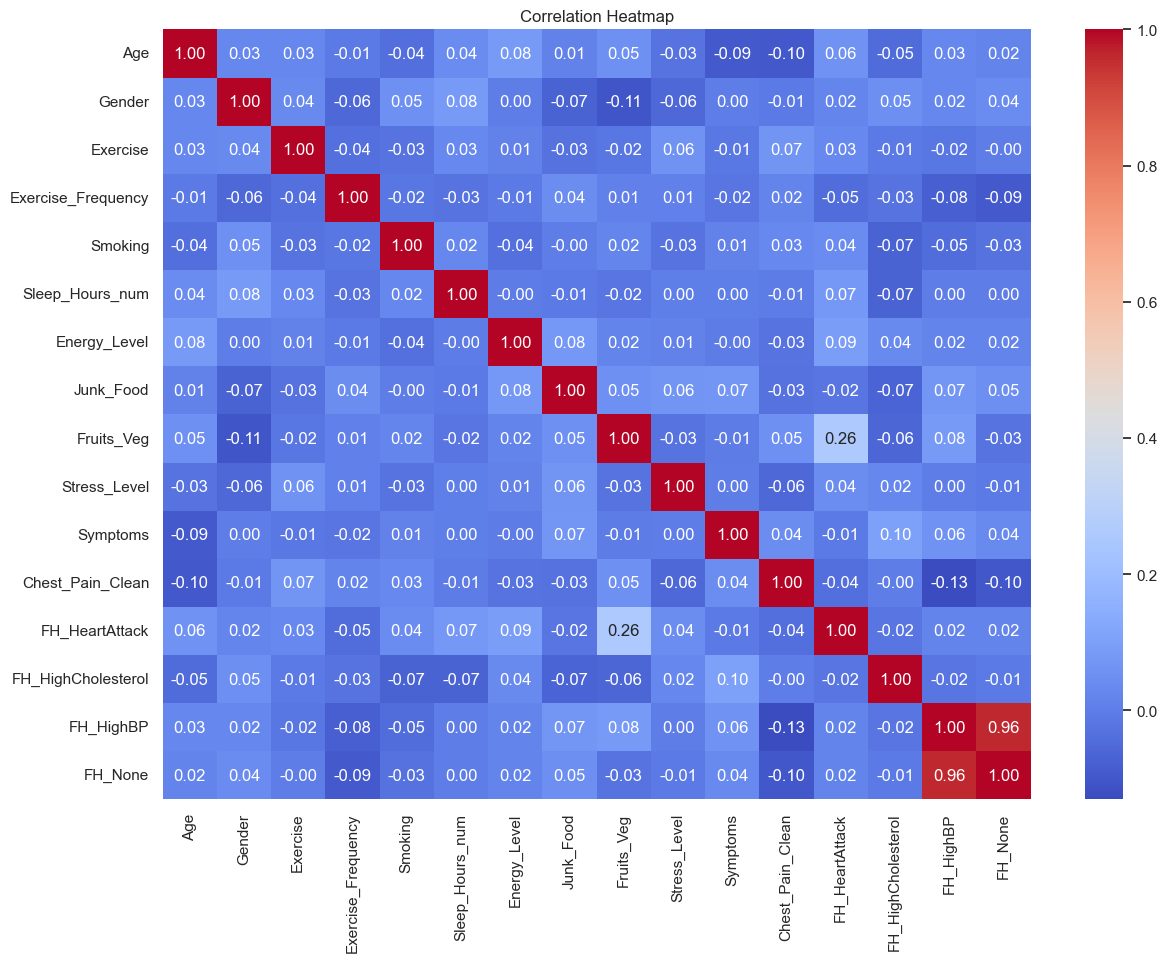


=== MODEL PERFORMANCE ===
Accuracy: 0.8766

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         1.0       0.92      0.90      0.91        51
         2.0       0.85      0.82      0.84        56
         3.0       0.86      0.91      0.89        47

    accuracy                           0.88       154
   macro avg       0.88      0.88      0.88       154
weighted avg       0.88      0.88      0.88       154


=== CONFUSION MATRIX ===
[[46  4  1]
 [ 4 46  6]
 [ 0  4 43]]


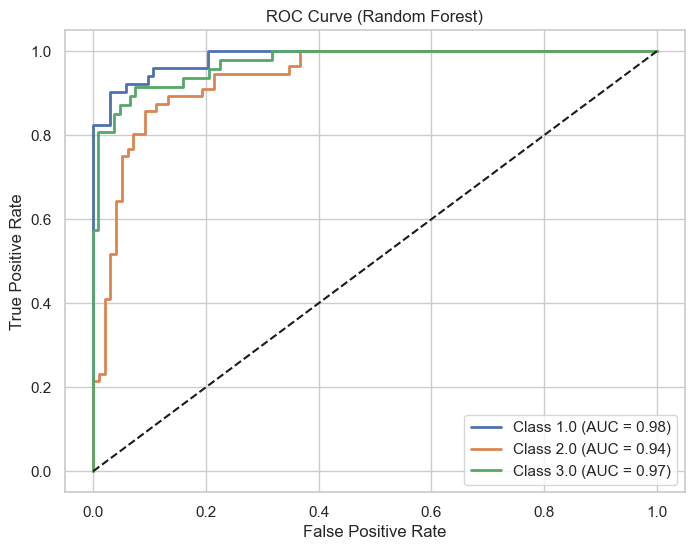

In [1]:
# ============================================================
#                 1. IMPORT LIBRARIES
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_curve, auc
)

from imblearn.over_sampling import SMOTE
sns.set(style="whitegrid")

# ============================================================
#                 2. LOAD DATA
# ============================================================

df = pd.read_csv(r"C:/Users/nikhi/OneDrive/Desktop/cvd_project/cvd.xlsx - Form Responses 1.csv",encoding="latin1")

# ============================================================
#        3. RENAME COLUMNS FOR CLEANING / PROCESSING
# ============================================================

mapping = {
 "Do you do any exercise ": "Exercise",
 "How many times per week do you exercise?": "Exercise_Frequency",
 "Do you smoke?": "Smoking",
 "How many hours do you sleep?": "Sleep_Hours",
 "How would you rate your daily energy level?": "Energy_Level",
 "How often do you consume fast food / junk food": "Junk_Food",
 "Please indicate the frequency of consumption of the following food groups: [Fruits and Vegitable]": "Fruits_Veg",
 "Rate your overall stress level ": "Stress_Level",
 "Do you have any of the following?": "Symptoms",
 "Do yo have any of the chest pain from these ?": "Chest_Pain",
 "Have any of your immediate family members been diagnosed with any of the cardiovascular conditions? [Heart Attack]": "FH_HeartAttack",
 "Have any of your immediate family members been diagnosed with any of the cardiovascular conditions? [High Cholesterol]": "FH_HighCholesterol",
 "Have any of your immediate family members been diagnosed with any of the cardiovascular conditions? [High blood pressure]": "FH_HighBP",
 "Have any of your immediate family members been diagnosed with any of the cardiovascular conditions? [None]": "FH_None"
}

df = df.rename(columns=mapping)

# ============================================================
#                 4. DATA CLEANING
# ============================================================

def clean_cp(val):
    v = str(val).lower().strip()
    if "typical" in v: return 3
    if "non" in v: return 2
    if "asym" in v: return 1
    if "none" in v: return 0
    return None

df["Chest_Pain_Clean"] = df["Chest_Pain"].apply(clean_cp)

df["Smoking"] = df["Smoking"].astype(str).str.lower().map({
    "yes": 1, "no": 0, "sometime": 0.5
})

def convert_sleep(x):
    try:
        if "-" in str(x):
            a, b = str(x).replace("hours", "").strip().split("-")
            return (float(a) + float(b)) / 2
    except:
        return None
    return None

df["Sleep_Hours_num"] = df["Sleep_Hours"].apply(convert_sleep)

clean_cols = [
    "Age","Gender","Exercise","Exercise_Frequency","Smoking","Sleep_Hours_num",
    "Energy_Level","Junk_Food","Fruits_Veg","Stress_Level","Symptoms",
    "Chest_Pain_Clean","FH_HeartAttack","FH_HighCholesterol","FH_HighBP","FH_None"
]

df_clean = df[clean_cols].copy()
df_clean = df_clean.dropna(subset=["Chest_Pain_Clean"])

# ============================================================
#                  5. ENCODING
# ============================================================

df_encoded = df_clean.copy()
le = LabelEncoder()

for col in df_encoded.columns:
    if df_encoded[col].dtype == "object":
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# ============================================================
#                 6. EDA — UNIVARIATE
# ============================================================

num_cols = df_encoded.select_dtypes(include=["float64","int64"]).columns
cat_cols = df_clean.select_dtypes(include="object").columns

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df_encoded[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(y=df_clean[col])
    plt.title(f"Countplot of {col}")
    plt.show()

# ============================================================
#             7. EDA — BIVARIATE
# ============================================================

for col in ["Age","Sleep_Hours_num","Energy_Level","Exercise_Frequency"]:
    plt.figure(figsize=(7,4))
    sns.boxplot(x=df_clean["Chest_Pain_Clean"], y=df_clean[col])
    plt.title(f"Chest Pain vs {col}")
    plt.show()

cat_bv = ["Gender","Exercise","Smoking","Junk_Food","Fruits_Veg",
          "Stress_Level","Symptoms","FH_HeartAttack",
          "FH_HighCholesterol","FH_HighBP","FH_None"]

for col in cat_bv:
    plt.figure(figsize=(7,4))
    sns.countplot(x=df_clean[col], hue=df_clean["Chest_Pain_Clean"])
    plt.title(f"{col} vs Chest Pain")
    plt.xticks(rotation=45)
    plt.show()

# ============================================================
#              8. CORRELATION HEATMAP
# ============================================================

plt.figure(figsize=(14,10))
sns.heatmap(df_encoded.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# ============================================================
#                 9. MACHINE LEARNING WITH SMOTE
# ============================================================

# Features & Target
X = df_encoded.drop("Chest_Pain_Clean", axis=1)
y = df_encoded["Chest_Pain_Clean"]

# --- Fix missing values (SMOTE requires no NaN) ---
X = X.fillna(X.median(numeric_only=True))

# Apply SMOTE BEFORE Train/Test split
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Train-test split on balanced data
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.20, random_state=42
)

# Random Forest Model
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)

# Prediction
y_pred = rf.predict(X_test)
# =============================
# FINAL MODEL PERFORMANCE OUTPUT
# =============================

print("\n=== MODEL PERFORMANCE ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))

print("\n=== CONFUSION MATRIX ===")
print(confusion_matrix(y_test, y_pred))

# ============================================================
#             11. ROC CURVE
# ============================================================

classes = sorted(y.unique())
y_test_bin = label_binarize(y_test, classes=classes)

y_pred_prob = rf.predict_proba(X_test)

plt.figure(figsize=(8,6))

for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {cls} (AUC = {roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.legend()
plt.show()



